In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import quad


class Simaan():
    def __init__(self):
        #Simulation Time
        self.start_t = 0 
        self.passo = 0.0001
        self.end_t = 4

        #Uses the already created Time Scale
        self.T = list(np.arange(self.start_t,self.end_t,self.passo)) #
        self.n = len(self.T)
        
        #Cardiovascular System
        self.HR = 60
        self.Emax = 2.5 #Amplitude da função elastância
        self.Emin = 0.06
        self.tc = 60/self.HR #Intervalo de tempo referente à duração de um ciclo cardíaco
        self.t_max = 0.2 + 0.15*self.tc; #Tempo máximo da duração de um ciclo cardíaco
      
        self.E = self.elastance(self.T) #Elastância normalizada
        

        #Cardiovascular System Model Parameters (from Simaan2009)

        #Valores de resistores,fontes e bobina 
        self.Rs  = 1.0000 #Resistência sistêmica vascular
        self.Rm  = 0.0050 #Resistência da válvula mitral
        self.Cae = 4.4000 #Elastância no átrio esquerdo
        self.Ra  = 0.0010 #Resistência da válvula aorta
        self.Rc  = 0.0398 #Characteristics Resistance
        self.Cs  = 1.3300 #Elastância sistêmica
        self.Cao = 0.0800 #Elastância na aorta
        self.Ls  = 0.0005 #Inertância sanguinea na aorta

        self.Vo = 10 #Pressão Inicial

        #PreAllocating
        self.Pao = np.zeros_like(self.T) #Pressão na aorta
        self.Qa  = np.zeros_like(self.T) #Fluxo na aorta
        self.Vve = np.zeros_like(self.T) #Volume no ventrículo esquerdo
        self.Pas = np.zeros_like(self.T) #Pressão na aorta sistêmica
        self.Pae = np.zeros_like(self.T) #Pressão no átrio esquerdo
        self.Pve = np.zeros_like(self.T) #Pressão no ventrículo esquerdo
        self.Dm_ = np.zeros_like(self.T) 
        self.Da_ = np.zeros_like(self.T) 


        #Initial Conditions
        self.Pao[0] = 90
        self.Qa[0]  = 0
        self.Vve[0] = 140 
        self.Pas[0] = 90
        self.Pae[0] = 10

        self.Pve[0] = self.E[0]* (self.Vve[0] - self.Vo) 

        #x = [x1 x2 x3 x4 x5]
        self.x = np.transpose([self.Pao[0], self.Qa[0], self.Vve[0], self.Pas[0], self.Pae[0]])

        #Initial States of diodes
        self.Dm = 0
        self.Da = 0

    def elastance(self, t):

        tn = np.asarray(t)%self.tc/self.t_max;
        En = 1.55 * np.power(np.asarray(tn)/.7, 1.9) / (1 + np.power(np.asarray(tn)/.7, 1.9)) / (1 + np.power(np.asarray(tn)/1.17, 21.9))
        return (self.Emax-self.Emin)*En + self.Emin


In [ ]:
def runkut4(passo,A,x,B,i):
    A = np.array(A);
    x = np.array(x);
    B = np.array(B);

    xdot = np.matmul(A, x) + B;
    kx1 = passo*xdot
  
    x1 = x + 0.5*kx1
    xdot = np.matmul(A, x1) + B
    kx2 = passo*xdot
    
    x1 = x + 0.5*kx2
    xdot = np.matmul(A, x1) + B
    kx3 = passo*xdot

    x1 = x + kx3
    xdot = np.matmul(A, x1) + B
    kx4 = passo*xdot

    value = np.asarray(x + (kx1 + 2*kx2 + 2*kx3 + kx4)/6)

    return value


In [ ]:
import operator
import functools as ft 

model = Simaan()
for i in range(model.n-1):
    
    #ramp function
    if model.Pae[i] >= model.Pve[i]:
      model.Dm = 1
    else:
      model.Dm = 0

    if model.Pve[i] >= model.Pao[i]:
      model.Da = 1
    else:
      model.Da = 0
    
    #A e B são matrizes variantes no tempo
    #Matriz A, 5X5
    a13 = (model.Da)/(model.Ra) * (model.E[i])
    a33 = -(((model.Dm)/(model.Rm)) + ((model.Da)/(model.Ra)))*model.E[i]
    a53 = (model.Dm)/(model.Rm) * model.E[i]
    a55 = -((1/(model.Rs))+((model.Dm)/(model.Rm)))

    # x = [ x1 x2 x3 x4 x5 ] 
    A = [[0], [0], [0], [0], [0]];
    A[0] = [-((model.Da)/(model.Ra)), -1, a13, 0, 0]/np.array(model.Cao)
    A[1] = [1, -(model.Rc), 0, -1, 0]/np.array(model.Ls)
    A[2] = [(model.Da)/(model.Ra), 0, a33, 0, (model.Dm)/(model.Rm)]
    A[3] = [0, 1, 0, -1/(model.Rs), 1/(model.Rs)]/np.array(model.Cs);
    A[4] = [0, 0, a53, 1/(model.Rs), a55]/np.array(model.Cae);
   

    #Matriz B, 5X1
    B = [-(((model.Da)/(model.Ra))*model.E[i]*model.Vo)/model.Cao,
         0,
         ((model.Dm)/(model.Rm) + (model.Da)/(model.Ra))*model.E[i]*model.Vo,
         0,
         ( -((model.Dm)/(model.Rm))*model.E[i]*model.Vo)/model.Cae]

    model.x =  runkut4(model.passo, A, model.x, B,i)
    
    
    #Atualizar as variáveis de estado do próximo ciclo
    model.Pao[i+1] =  model.x[0]
    model.Qa[i+1]  =  model.x[1]
    model.Vve[i+1] =  model.x[2]
    model.Pas[i+1] =  model.x[3]
    model.Pae[i+1] =  model.x[4]
    model.Pve[i+1] = model.E[i+1] * (model.Vve[i+1] - model.Vo)


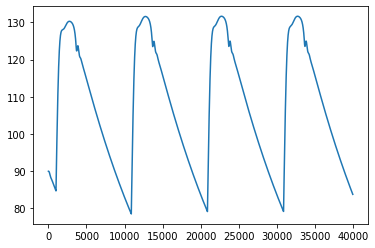

In [ ]:
#PLOT

import matplotlib.pyplot as plt
  
plt.plot(model.Pao)
plt.show()